In [1]:
# importing the dependencies
from itertools import product as itp
from pythtb import *
from triqs.lattice.tight_binding import TBLattice
import sympy as sp
import warnings
import numpy as np
import matplotlib.pyplot as plt

Starting serial run at: 2023-08-01 14:50:52.694093


In [2]:
def TB_to_sympy(TBL, analytical = True, precision = 6):
    r"""
    returns the analytical form of the momentum space hamiltonian of the tight-binding model 
    from a tight-binding lattice object by utilizing Fourier series
    
    Parameters
    ----------
    TBL: triqs TBLattice object
        triqs tight binding object
    analytical: boolean, default = True
        a boolean which will cause the function will return an analytical Hamiltonian, when true, and 
        an numerical Hamiltonian otherwise
    precision: integer, default = 6
        specifies the precision of the floating point amplitudes. The default precision is 6 but the user
        can decrease this parameter for better recognition of similar hopping amplitudes, particularly
        for symmetrical hoppings across the crystal lattice
    
    Returns
    -------
    Hk: NumPy array
        the Hamiltonian of the tight-binding model in momentum space. It can be output in either numerical
        form (Hk_numerical) or reduced analytical form (Hk) based on the user's choice. The default output
        is the reduced analytical form. The numerical form depends solely on the k-space vector components
        while the analytical form takes into account both the k-space vector components and the lattice
        vectors

    """

    # imaginary number
    I = sp.I

    # matrix from axis directions in momentum space
    kx, ky, kz = sp.symbols("kx ky kz", real = True)
    k_space_matrix = sp.Matrix([kx, ky, kz])

    # symbolic dot product representation between lattice unit vectors
    # and momentum space matrix
    a1k, a2k, a3k = sp.symbols("a1k a2k a3k", real = True)
    lattice = sp.Matrix([a1k, a2k, a3k])

    # units contains the displacement vectors
    # hops contains details about hopping of electrons such as orbital
    # and hopping amplitude
    if TBL.units.shape == (2, 2):
        TBL_units = np.eye(3)
        TBL_units[:2, :2] = TBL.units
        TBL_hops = {key + (0,): val for key, val in TBL.hoppings.items()}
    elif TBL.units.shape == (3,3):
        TBL_units = TBL.units
        TBL_hops = TBL.hoppings
    # raises error for when the dimensions of the tb object is neither 2D nor 3D
    else:
        raise ValueError("This format of the tight-binding model is not implemented for this function.")
   
    # number of orbitals involved in the unit cell
    num_orb = TBL.n_orbitals

    # maximum hopping distances of electrons in each direction
    max_x, max_y, max_z = list(np.max(np.array(list(TBL_hops.keys())), axis = 0))

    # number of cells involved in the hopping of electrons in each direction
    num_cells_x, num_cells_y, num_cells_z = [2 * max_coord + 1 for max_coord in [max_x, max_y, max_z]]
    
    # real-space Hamiltonian
    Hrij = np.zeros((num_cells_x, num_cells_y, num_cells_z, num_orb, num_orb), dtype = sp.exp)

    # looping through hopping parameters of electrons involved in inter-orbital hoppings
    for key, hopping in TBL_hops.items():
        rx, ry, rz = key
        hopping = np.around(hopping, precision)
        Hrij[rx + max_x, ry + max_y, rz + max_z] = hopping
        
    # basis of the exponential term in calculation of Hk
    Hexp = np.empty_like(Hrij, dtype = sp.exp)

    # perform Fourier transform
    for xi, yi, zi in itp(range(num_cells_x), range(num_cells_y), range(num_cells_z)):
        coefficients = np.array([xi - max_x, yi - max_y, zi - max_z])
        r = lattice.dot(coefficients)
        eikr = sp.exp(-I * r)
        Hexp[xi, yi, zi, :, :] = eikr

    # summation over all real space axes
    Hk = np.sum(Hrij * Hexp, axis = (0, 1, 2))
    
    # rewriting exponential terms in Hamiltonian expression in terms of cosine
    for i, j in itp(range(num_orb), repeat = 2):
        Hk[i, j] = Hk[i, j].rewrite(sp.cos)

    # dealing with the numerical Hamiltonian

    # convert to SymPy matrix to use substitutions method available in SymPy
    Hk_numerical = sp.Matrix(Hk)

    # obtaining individual displacement vectors
    a1 = np.around(TBL_units[0], precision)
    a2 = np.around(TBL_units[1], precision)
    a3 = np.around(TBL_units[2], precision)

    # numerical dot products between unit vectors
    # and momentum space matrix
    a1k_numerical = a1.dot(k_space_matrix)[0]
    a2k_numerical = a2.dot(k_space_matrix)[0]
    a3k_numerical = a3.dot(k_space_matrix)[0]
    
    # performing numerical dot product substitutions
    Hk_numerical = Hk_numerical.subs(a1k, a1k_numerical)
    Hk_numerical = Hk_numerical.subs(a2k, a2k_numerical)
    Hk_numerical = Hk_numerical.subs(a3k, a3k_numerical)

    # converting numerical Hamiltonian to NumPy array
    Hk_numerical = np.array(Hk_numerical)

    def _has_complex_exponential_sympy(matrix):
        """
        Checks if a NumPy array containing SymPy elements has a complex exponential element.

        Args:
            matrix (NumPy array): The input NumPy array containing SymPy elements
        
        Returns:
            bool: True if the matrix array contains a complex exponential element, False otherwise.

        """

        for sublist in matrix:
            for element in sublist:
                if element.is_complex and element.has(sp.exp):
                    return True
        return False
    
    def _is_hermitian_sympy(matrix):
        """
        Checks if a NumPy array containing SymPy elements is hermitian

        Args:
            matrix (NumPy array): The input NumPy array containing SymPy elements
        
        Returns:
            bool: True if the matrix is a hermitian, False otherwise

        """
        
        n = matrix.shape[0]
        for i in range(n):
            for j in range(n):
                if matrix[i, j] != matrix[j, i].conjugate():
                    return False
        return True
    
    # warning indicating when Hamiltonian is not hermitian
    if _is_hermitian_sympy(Hk) == False or _is_hermitian_sympy(Hk_numerical) == False:
        return warnings.warn("The resulting Hamiltonian is not hermitian.")

    # warning indicating when Hamiltonian contains complex exponential element
    if _has_complex_exponential_sympy(Hk_numerical) or _has_complex_exponential_sympy(Hk):
        return warnings.warn("""Your expression has a complex exponential. 
                                Choosing a different unit cell could make 
                                your Hamiltonian expression real.""")
    
    # returning analytical or numerical form of Hamiltonian
    if analytical:
        return Hk
    return Hk_numerical

In [20]:
from triqs.lattice.utils import TB_from_pythTB
w90_input = w90('La2CuO4 Files', 'lco')
fermi_ev = 12.7367
w90_model = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = 0.05, max_distance = None)
w90_triqs = TB_from_pythTB(w90_model)

In [21]:
print("The analytical expression \n", TB_to_sympy(w90_triqs, analytical = True, precision = 6))
# print("The numerical expression \n", TB_to_sympy(w90_triqs, analytical = False, precision = 3))
# print("The less precise numerical expression \n", TB_to_sympy(w90_triqs, analytical = False, precision = 3))

The analytical expression 
 [[-0.880642*cos(a1k + a3k) - 0.880642*cos(a2k + a3k) + 0.158922]]


In [22]:
print(dict(w90_triqs.hoppings.items()))
print(len(dict(w90_triqs.hoppings.items())))

{(0, 0, 0): array([[0.158922+0.j]]), (0, 1, 1): array([[-0.440321+0.j]]), (0, -1, -1): array([[-0.440321+0.j]]), (1, 0, 1): array([[-0.440321+0.j]]), (-1, 0, -1): array([[-0.440321+0.j]])}
5


In [6]:
epsilon = 0.158922
t1 = 0.440321
t2 = 0.038151

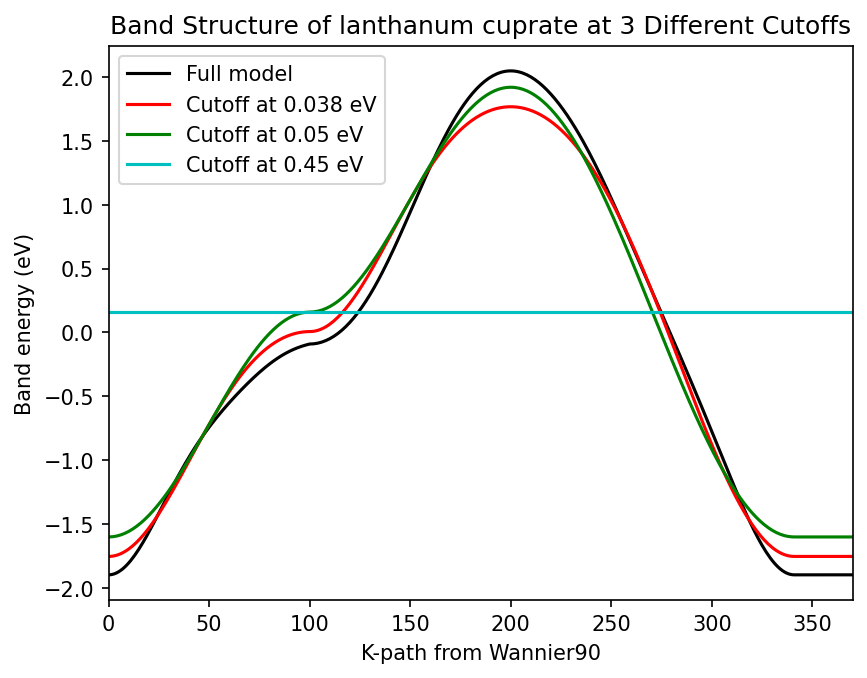

In [8]:
def compareBandStructure(w90_input, fermi_ev): 
    # get band structure from wannier90
    # BLACK - the full model
    # the purpose of this function is to compare the interpolation in W90 with that in PythTB
    # returns kpts (k-points in reduced coordinates used in the interpolation in W90 code) and
    # ene (energies interpolated by W90 in the form of ene[band, kpoint])
    (w90_kpt, w90_evals) = w90_input.w90_bands_consistency()

    # get the simplified model by introducing cutoff parameters
    w90_model_038 = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = 0.038, max_distance = None)
    w90_model_05 = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = 0.05, max_distance = None)
    w90_model_45 = w90_input.model(zero_energy = fermi_ev, min_hopping_norm = 0.45, max_distance = None)

    # RED - the reduced model
    # solve simplified model on the same k-path as in wannier90
    # solves for eigenvalues and (optionally) eigenvectors of the TB model on a given 1D list of k-vectors
    int_evals_038 = w90_model_038.solve_all(w90_kpt)
    int_evals_05 = w90_model_05.solve_all(w90_kpt)
    int_evals_45 = w90_model_45.solve_all(w90_kpt)

    # plotting the comparison of the 2 models

    # the plotting
    fig, ax = plt.subplots(dpi = 150)

    for i in range(w90_evals.shape[0]):
        x_axis = list(range(w90_evals.shape[1]))
        y_axis = w90_evals[i] - fermi_ev
        ax.plot(x_axis, y_axis, "k-", zorder = -100)

    # the reduced model
    for i in range(int_evals_038.shape[0]):
        ax.plot(list(range(int_evals_038.shape[1])), int_evals_038[i], "r-", zorder = -50)
        ax.plot(list(range(int_evals_05.shape[1])), int_evals_05[i], "g-", zorder = -50)
        ax.plot(list(range(int_evals_45.shape[1])), int_evals_45[i], "c-", zorder = -50)
    
    ax.set_xlim(0, int_evals_038.shape[1] - 1)
    ax.set_xlabel("K-path from Wannier90")
    ax.set_ylabel("Band energy (eV)")
    ax.set_title(r"Band Structure of lanthanum cuprate at 3 Different Cutoffs")
    ax.legend(["Full model", "Cutoff at 0.038 eV", "Cutoff at 0.05 eV", "Cutoff at 0.45 eV"])

# calling the function
lanthanum_w90_input = w90('La2CuO4 Files', 'lco')
compareBandStructure(lanthanum_w90_input, 12.7367)